In [2]:
%reload_ext autoreload
%autoreload 2

# %matplotlib widget
%gui qt

import time
import random
from copy import copy
from tqdm import tqdm
from pathlib import Path
import numpy as np
import numba as nb
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt

from vrAnalysis import session
from vrAnalysis import functions
from vrAnalysis import analysis 
from vrAnalysis import helpers
from vrAnalysis import fileManagement as fm
from vrAnalysis import database

from vrAnalysis.redgui import redCellGUI as rgui

vrdb = database.vrDatabase()

In [6]:
# Immediate next steps for programming work:
# - ROICaT index alignment tools

In [241]:
# Database Requirements: 
# ---------------------
# GUI: db manager
# - show full database -
# - show selected entries (like for example entries with imaging but no suite2p) -
#                --> It would be sweet to make this work where there are some defaults, but then there is also a "filter command" option which you type and goes as the input to the filtering
# - click on entry and do things:
#                --> open file explorer to that session
#                --> do suite2p
#                --> do red cell management
# - update table data? 
# ---------------------
# Operational Commands: 
# - Automatically do suite2p 
# - Check if registration was done before a suite2p update
# - Find way to determine if a suite2p file was updated after the folder was made (indicating that QC was done afterwards) -- so registration should be rerun for imaging data at least
#    -- check if "iscell" is the only thing that was done after registration. In this case, just update the iscell oneData
# ---------------------
# - Add new entry GUI!!!
# ---------------------
# - Check session folders to see if new session is present that isn't registered in the database? 
# ---------------------
# vrExperimentUpdates: 
# -- if edited iscell, will need to re-register the number of ROIs per plane (in "self.values") and reprocess imaging data!
# ---------------------
# vrExperimentRegistration
# -- if error, then note there was an error and append an explanation...!!!
# ---------------------

In [2]:
mouseName = 'CR_Hippocannula6'
dateString = '2022-09-05'
sessionid = '701'
# vrExperiment registration and preprocessing 
# vrReg = vre.vrExperimentRegistration(mouseName, dateString, session, oasis=False, imaging=True)
# vrReg.processTimeline()
# vrReg.processImaging()
# vrReg.processRedCells()
# vrReg.saveParams()
# print(vrReg.sessionPath())
# del vrReg

In [4]:
mouseName = 'ATL012'
dateString = '2023-02-01'
sessionid = '701'

# Load registered vrExperiment
vrexp = session.vrExperiment(mouseName, dateString, sessionid)

In [3]:
mouseName = 'ATL027'
dateString = '2023-08-01'
sessionid = '701'

# Load registered vrExperiment
vrexp = session.vrExperiment(mouseName, dateString, sessionid)

In [ ]:
# # vrExperiment registration and preprocessing 
# vrReg = vre.vrExperimentRegistration(mouseName, dateString, session, oasis=False, imaging=True)
# vrReg.doPreprocessing()
# vrReg.saveParams()
# print(vrReg.sessionPath())
# del vrReg

In session: ATL020/2023-05-04/702, vrFile['rigInfo'] does not exist. Assuming default settings for B2!
Self.value['numTrials'] set by trialInfo.trialIdx>0, but this might not be right. There might be smarter ways to determine which trials are 'good' trials...
frame2time had 2 more than suite2p output. This happens sometimes. I don't like it. I think it's because scanimage sends a TTL before starting the frame
Computing red cell features for ATL020/2023-05-04/702... (usually takes 10-20 seconds)
Facecam preprocessing has not been coded yet!
C:\Users\andrew\Documents\localData\ATL020\2023-05-04\702


In [103]:
# Load registered vrExperiment
vrexp = session.vrExperiment(mouseName, dateString, sessionid)

In [18]:
%%time
speedThreshold = 5
omap, smap, lickmap, distvec = functions.getBehaviorMaps(vrexp,speedThreshold=speedThreshold) # produce smoothed occupancy and speed maps, along with the distance bins used to create them
frameTrialIdx, framePosition, frameSpeed = vrexp.getFrameBehavior() # convert behavioral data into timeframe of spiking data
spkmap = functions.getSpikeMap(vrexp, frameTrialIdx, framePosition, frameSpeed, distvec, omap, speedThreshold=speedThreshold, standardizeSpks=False, doSmoothing=0) # produce the spkmap 
idxFullTrials = np.all(~np.isnan(omap),axis=1) # find out which trials the mouse explored the whole environment
relmse, relcor = functions.measureReliability(spkmap[:,idxFullTrials], numcv=3) # measure reliability of spiking
spInfo = functions.measureSpatialInformation(omap[idxFullTrials], spkmap[:,idxFullTrials]) # measure spatial information of spiking

CPU times: total: 3.77 s
Wall time: 898 ms


In [19]:
# Code block for opening redSelectionGUI for a vrExperiment
vrexp = session.vrExperiment(mouseName, dateString, sessionid)
redCell = session.redCellProcessing(vrexp)
redSelection = rgui.redSelectionGUI(redCell)

hi
we have a database
Successfully updated the redCellQC field of the database to True


In [16]:
redCell.sessionPrint()

'ATL027/2023-08-01/701'

In [18]:
vars(redCell)

{'mouseName': 'ATL027',
 'dateString': '2023-08-01',
 'session': '701',
 'opts': {'vrBehaviorVersion': 1,
  'facecam': True,
  'imaging': True,
  'oasis': True,
  'moveRawData': False,
  'redCellProcessing': True,
  'clearOne': True,
  'neuropilCoefficient': 0.7,
  'tau': 1.5,
  'fs': 6},
 'preprocessing': ['timeline', 'vrBehavior', 'imaging'],
 'value': {'numTrials': 109,
  'numBehaveTimestamps': 26506,
  'planeNames': ['plane0', 'plane1', 'plane2', 'plane3', 'plane4'],
  'planeIDs': [0, 1, 2, 3, 4],
  'available': ['iscell',
   'spks',
   'F',
   'redcell',
   'F_chan2',
   'ops',
   'stat',
   'Fneu',
   'Fneu_chan2'],
  'roiPerPlane': [3882, 3931, 3421, 3576, 4101],
  'framePerPlane': [12769, 12769, 12769, 12768, 12768],
  'numROIs': 18911,
  'numFrames': 12768,
  'samplingDeviationMedianPercentError': 1.0020564946365944,
  'samplingDeviationMaximumPercentError': 1.00602409638678},
 'loadBuffer': {'mpciROIs.stackPosition.npy': array([[390.91715387, 368.16326251,   0.        ],
    

In [165]:
scc.vrexp.sessionPrint()

'ATL027/2023-08-01/701'

In [183]:
# go through each session that has been registered and has imaging data
for ses in tqdm(vrdb.iterSessions(imaging=True, vrRegistration=True)):
    pass
    # scc = analysis.sameCellCandidates(ses)
    # scc.roiCountHandling(keepPlanes=[1,2,3,4], withSave=True, withShow=False)
    # scc.cdfForThresholds(ylim=None, cdfVals=np.linspace(-0.05,1,121), keepPlanes=[1,2,3,4], distanceCutoff=40, distanceDistant=(50, 250), withSave=True, withShow=False)
    # scc.clusterSize(verbose=False, withSave=True, withShow=False)
    # scc.distanceDistribution(withSave=True, withShow=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<?, ?it/s]


In [ ]:
# next step in analysis: 
# Also - using a cutoff point by the hitch in that distribution might ignore true matches that are soma-dendritic, but maybe I can use ROICaT or npix to avoid those? 

In [86]:
vrexp = random.choice(vrdb.iterSessions(imaging=True, vrRegistration=True))
print(vrexp.sessionPrint())
print(vrexp.suite2pPath())
scc = analysis.sameCellCandidates(vrexp, keepPlanes=[1,2,3,4])

ATL028/2023-08-07/701
C:\Users\andrew\Documents\localData\ATL028\2023-08-07\701\suite2p


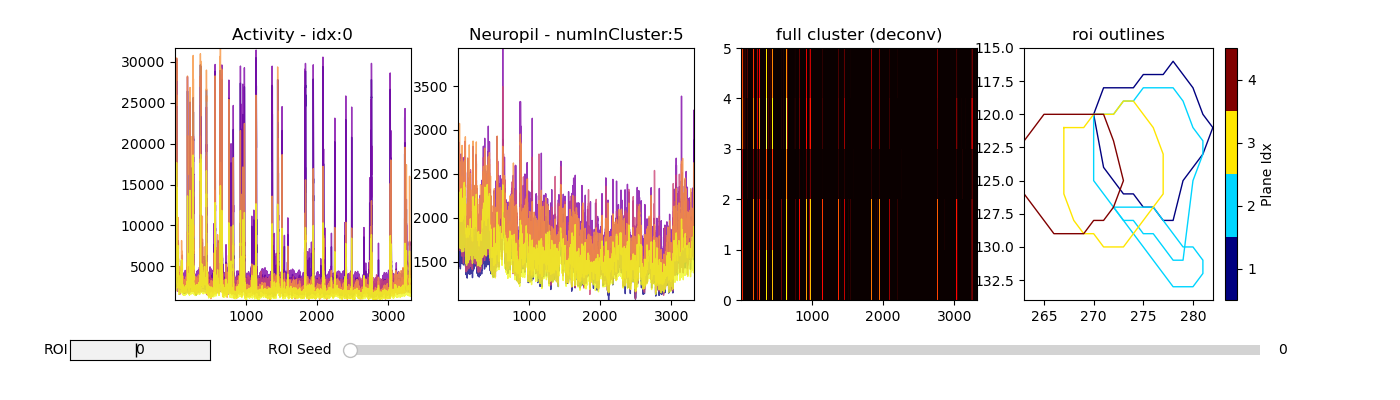

In [87]:
clusterExplorer = analysis.clusterExplorer(scc, corrCutoff=0.5, maxCutoff=None, distanceCutoff=30, minDistance=None, keepPlanes=[1,2,3,4])

In [ ]:
# okay, looking at these clusters, it seems like there is some serious oversplitting going on in suite2p. That sucks!
# I think I should probably try to rerun some suite2p sessions....
# But for now I'll probably do a "merge" procedure... and I honestly think I'll have to overwrite or add a new "modified" suite2p folder with the stat and ops files